In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 823
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
def generate():
    group_list = ["one","two","three","four","five"]
    trials_per_group = 20
    group_inters = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list))
    group_mx = group_inters * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate([np.ones(trials_per_group) * i for i in np.arange(len(group_list))]).astype(int)
    inters = np.repeat(group_inters, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx,1)
    y = rng.normal(inters + (x-mx) * slope, 1)
    data = pd.DataFrame({"group": group,"group_idx":subject, "x":x,"y":y})
    return data, group_list

In [4]:
data, group_list = generate()
display(data)

group  group_idx         x         y
0    one          0  1.633042  0.364977
1    one          0  1.167802  1.417679
2    one          0 -0.257528  0.932307
3    one          0  0.782763 -0.591873
4    one          0  0.998460  0.797498
..   ...        ...       ...       ...
95  five          4  0.427862  0.295892
96  five          4  1.152820  1.190922
97  five          4  0.346136  1.075920
98  five          4  2.605007  1.996957
99  five          4  0.559256 -0.052205

[100 rows x 4 columns]

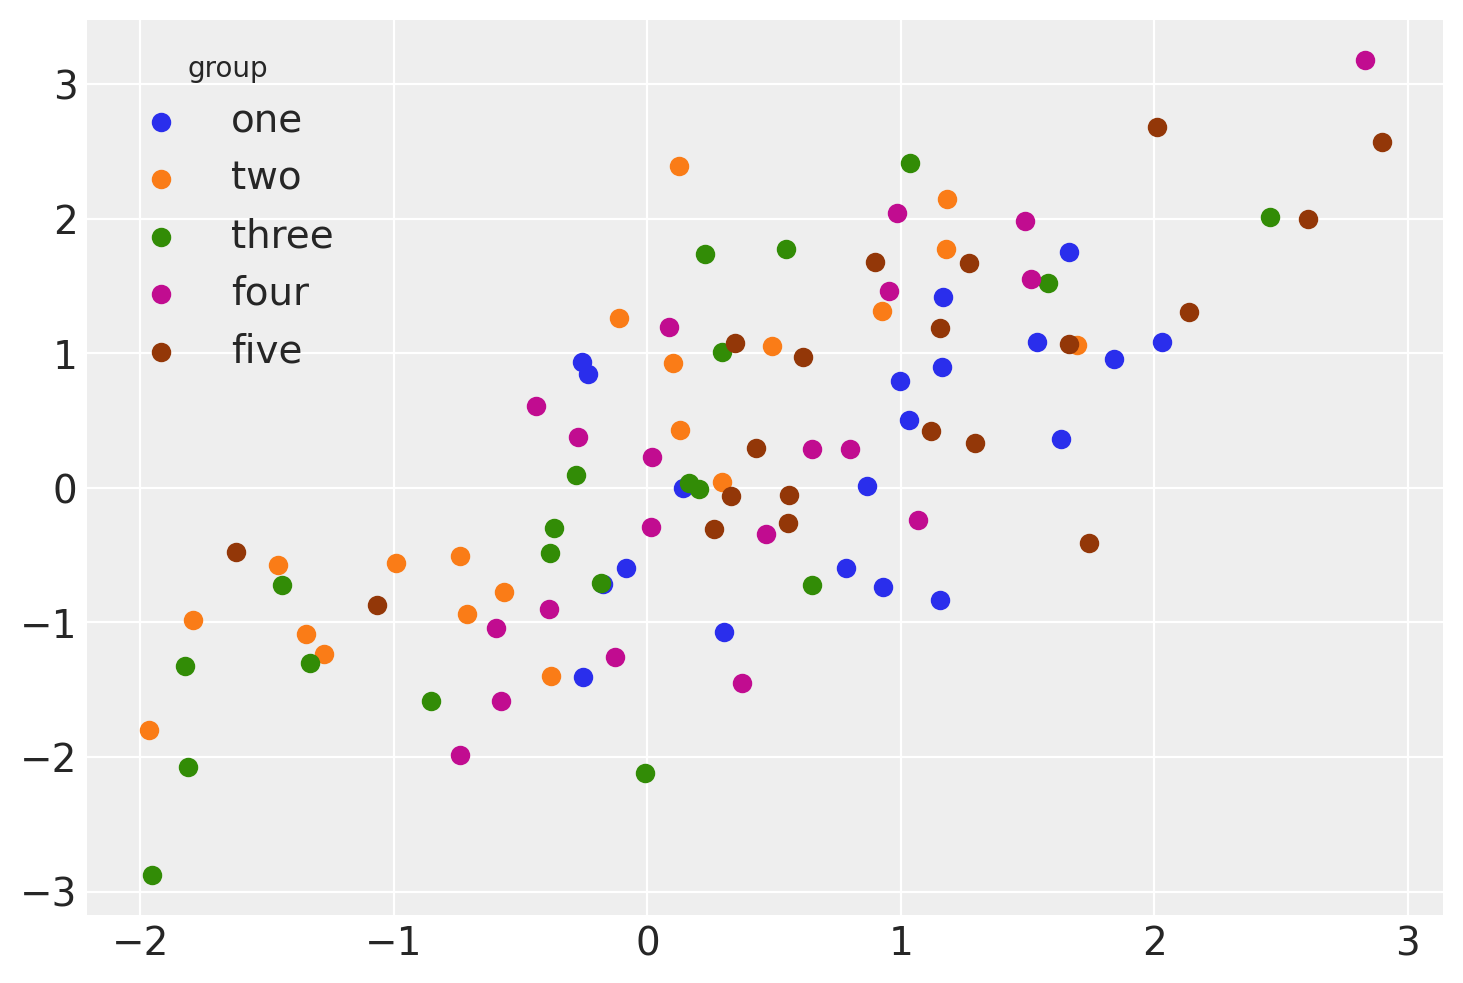

In [5]:
for i, group in enumerate(group_list):
    plt.scatter(
    data.query(f"group_idx=={i}").x,
    data.query(f"group_idx=={i}").y,
    color= f"C{i}",
    label =f"{group}",
    )
plt.legend(title="group");

In [6]:
with pm.Model() as lin_reg:
    sigma = pm.HalfCauchy("sigma", beta=2)
    beta0 = pm.Normal("beta0",0, sigma=5)
    beta1 = pm.Normal("beta1",0, sigma=5)
    x = pm.MutableData("x", data.x, dims="obs_id")
    mu = pm.Deterministic("mu", beta0 + beta1 * x, dims="obs_id")
    pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs_id")

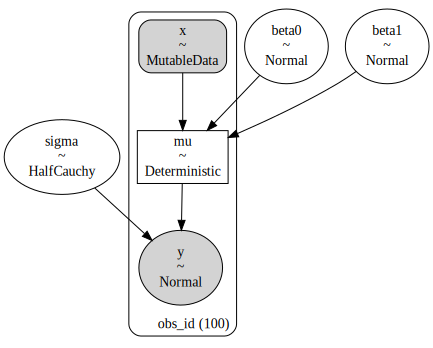

In [7]:
pm.model_to_graphviz(lin_reg)

In [8]:
with lin_reg:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


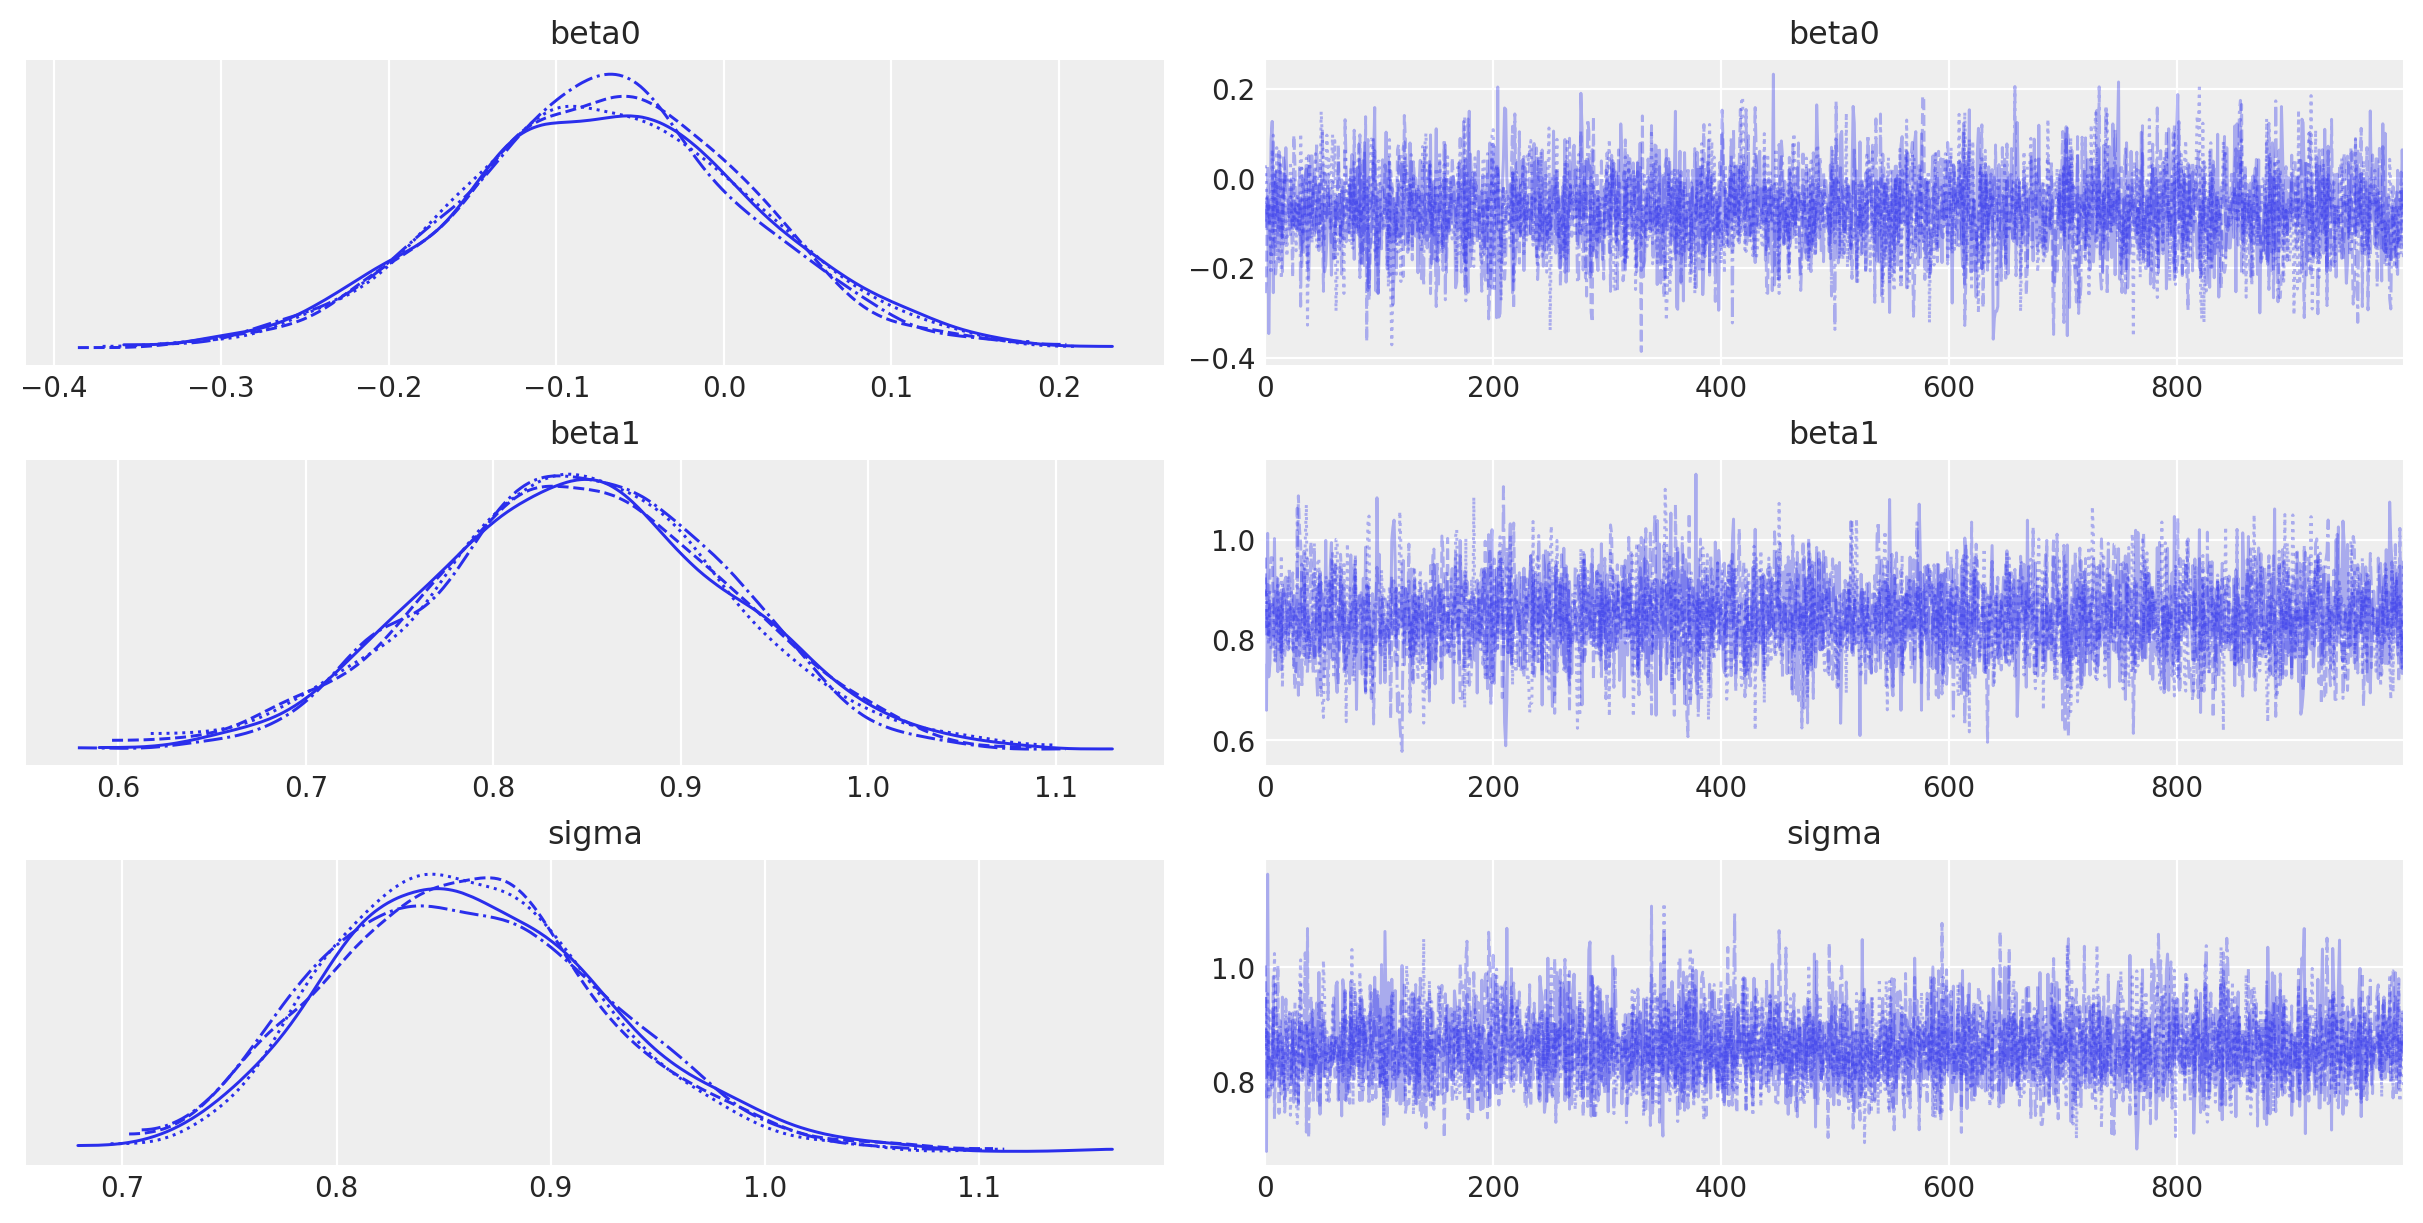

In [9]:
az.plot_trace(idata, filter_vars="regex", var_names=["~mu"]);

In [10]:
xi = np.linspace(data.x.min(), data.x.max(),20)
with lin_reg:
    pm.set_data({"x":xi})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["y","mu"]))

Sampling: [y]


In [13]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [15]:
az.summary(idata, round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0  -0.07  0.09   -0.24     0.10        0.0      0.0   4077.35   3095.21   
beta1   0.84  0.08    0.68     0.99        0.0      0.0   4440.94   3139.90   
sigma   0.86  0.06    0.75     0.98        0.0      0.0   4830.74   3018.04   
mu[0]   1.31  0.14    1.06     1.57        0.0      0.0   5635.18   3056.98   
mu[1]   0.92  0.11    0.72     1.12        0.0      0.0   6025.56   3217.59   
...      ...   ...     ...      ...        ...      ...       ...       ...   
mu[95]  0.29  0.09    0.13     0.45        0.0      0.0   5147.79   3313.87   
mu[96]  0.90  0.11    0.70     1.11        0.0      0.0   6042.51   3244.77   
mu[97]  0.22  0.09    0.06     0.38        0.0      0.0   4909.89   3064.84   
mu[98]  2.13  0.20    1.73     2.51        0.0      0.0   5145.16   2863.87   
mu[99]  0.40  0.09    0.24     0.56        0.0      0.0   5440.47   3404.78   

        r_hat  
beta0     1.0  
beta1     1.0  
sigma     1.0  
mu[0]     1.0  
mu[1]     1.0  
...       ...  
mu[95]    1.0  
mu[96]    1.0  
mu[97]    1.0  
mu[98]    1.0  
mu[99]    1.0  

[103 rows x 9 columns]

In [ ]:
#with lin_reg:
 #   pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [16]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, obs_id: 20)
Coordinates:
  * chain    (chain) int32 0 1 2 3
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * obs_id   (obs_id) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    y        (chain, draw, obs_id) float64 -1.836 -1.753 -0.2753 ... 2.472 3.271
    mu       (chain, draw, obs_id) float64 -1.775 -1.55 -1.325 ... 2.048 2.259
Attributes:
    created_at:                 2023-04-26T19:47:00.672867
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.1.2

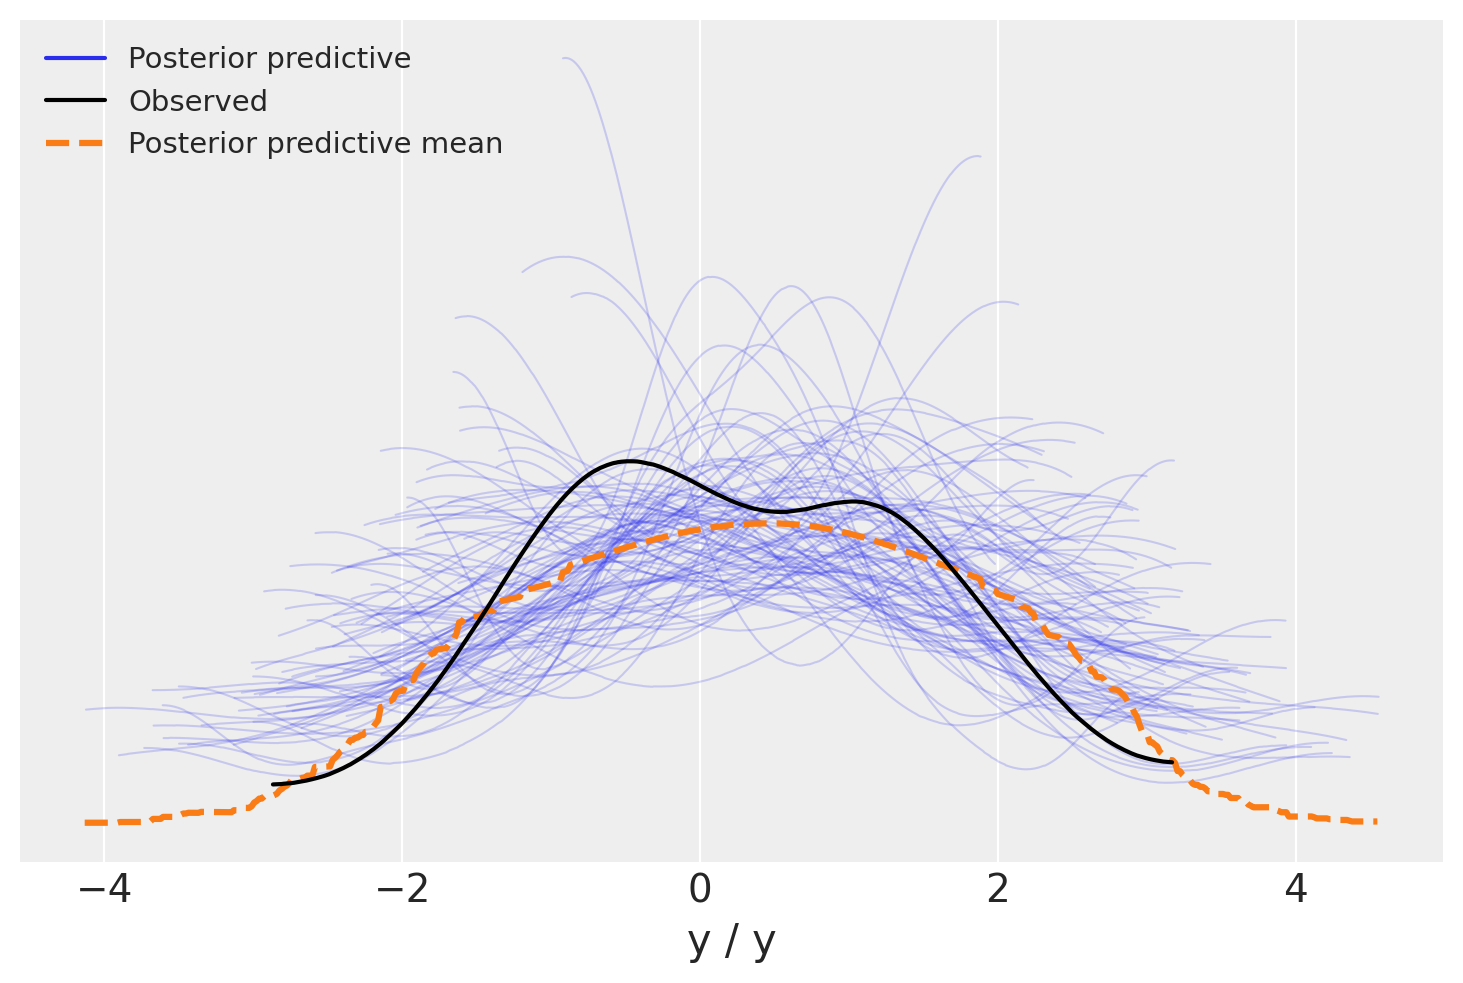

In [17]:
az.plot_ppc(idata, num_pp_samples=100);

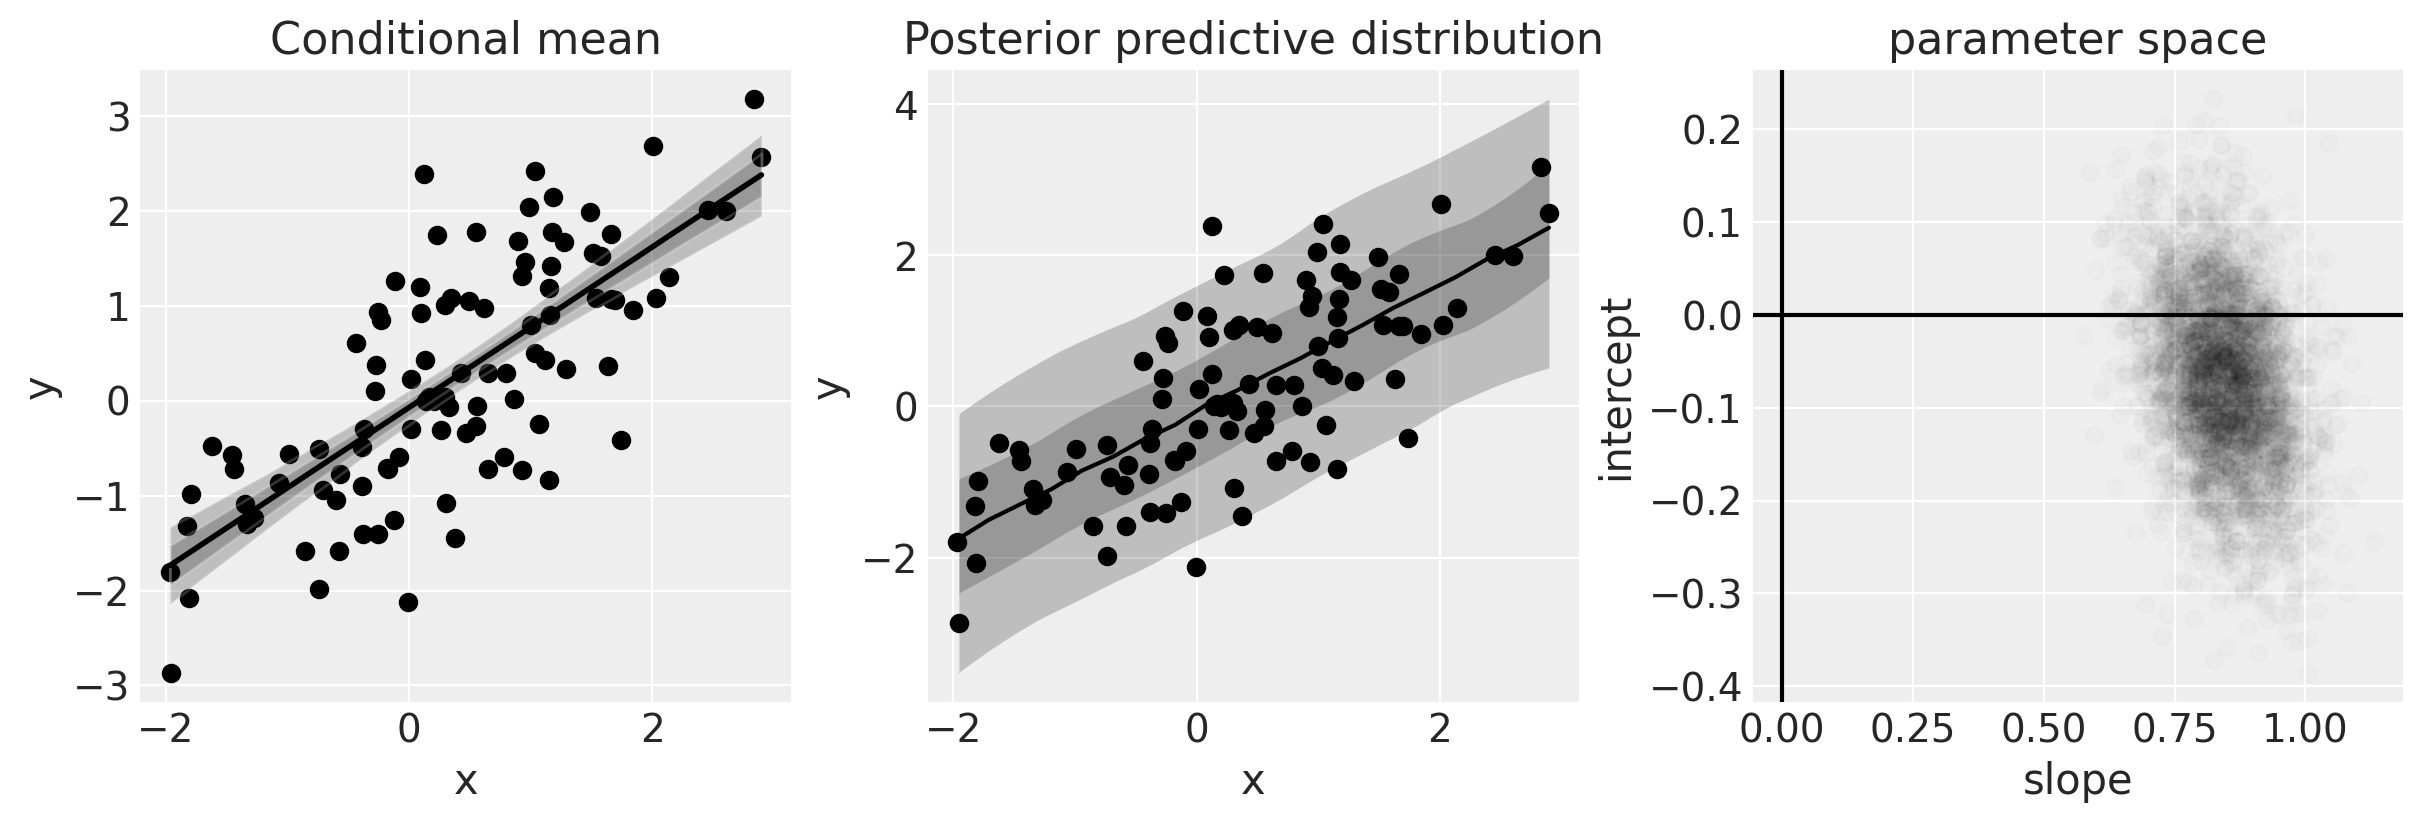

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].scatter(data.x, data.y, color="k")
#conditional mean credible intervals
post = az.extract(idata)
xi = xr.DataArray(np.linspace(np.min(data.x), np.max(data.x),20), dims=["x_plot"])
y = post.beta0 + post.beta1 * xi
region = y.quantile([.025, .15,.5,.85, .975], dim="sample")
ax[0].fill_between(
xi, region.sel(quantile=.025), region.sel(quantile=.975), alpha=.2, color='k', edgecolor='w'
)
ax[0].fill_between(
xi, region.sel(quantile=.15), region.sel(quantile=.85), alpha=.2, color='k', edgecolor='w'
)
#conditional mean
ax[0].plot(xi, region.sel(quantile=.5), "k", linewidth=2)
#format
ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")
#posterior prediction ---------------------
#data
ax[1].scatter(data.x, data.y, color='k')
#posterior mean and HDI
ax[1].plot(xi, idata.posterior_predictive.y.mean(["chain","draw"]), 'k')
az.plot_hdi(
xi, idata.posterior_predictive.y, hdi_prob=.6, color='k', fill_kwargs={"alpha":0.2, "linewidth":0},
    ax=ax[1],
)
az.plot_hdi(
xi, idata.posterior_predictive.y, hdi_prob=.95, color='k', fill_kwargs ={"alpha":0.2, "linewidth":0},
    ax=ax[1],
)
#format
ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")
#parameter space _______________-------
ax[2].scatter(
az.extract(idata, var_names=["beta1"]),
    az.extract(idata, var_names=["beta0"]),
    color = 'k',
    alpha = .01,
    rasterized= True,
)
#format
ax[2].set(xlabel="slope", ylabel="intercept", title="parameter space")
ax[2].axhline(y=0, c="k")
ax[2].axvline(x=0, c="k");

#### Model 2: Indepedent slopes and intercepts model

In [13]:
coords = {"group": group_list}

with pm.Model(coords=coords) as ind_slope_inter:
    #define priors
    sigma = pm.HalfCauchy("sigma",beta=2, dims="group")
    beta0 = pm.Normal("beta0", sigma=5, dims="group")
    beta1 = pm.Normal("beta1", sigma=5, dims="group")
    #data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    #Linear model
    mu = pm.Deterministic("mu", beta0[g] + beta1[g] *x, dims="obs_id")
    #define the likelihood
    pm.Normal("y", mu=mu, sigma=sigma[g], observed=data.y, dims="obs_id")

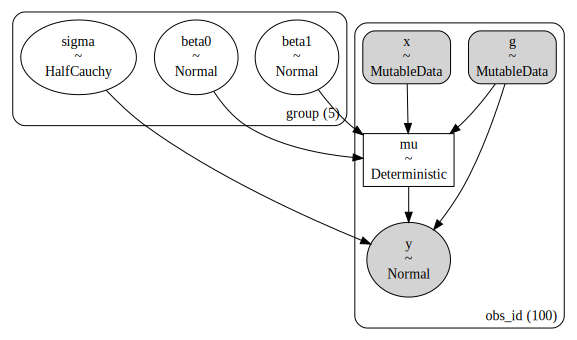

In [14]:
pm.model_to_graphviz(ind_slope_inter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta0, beta1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


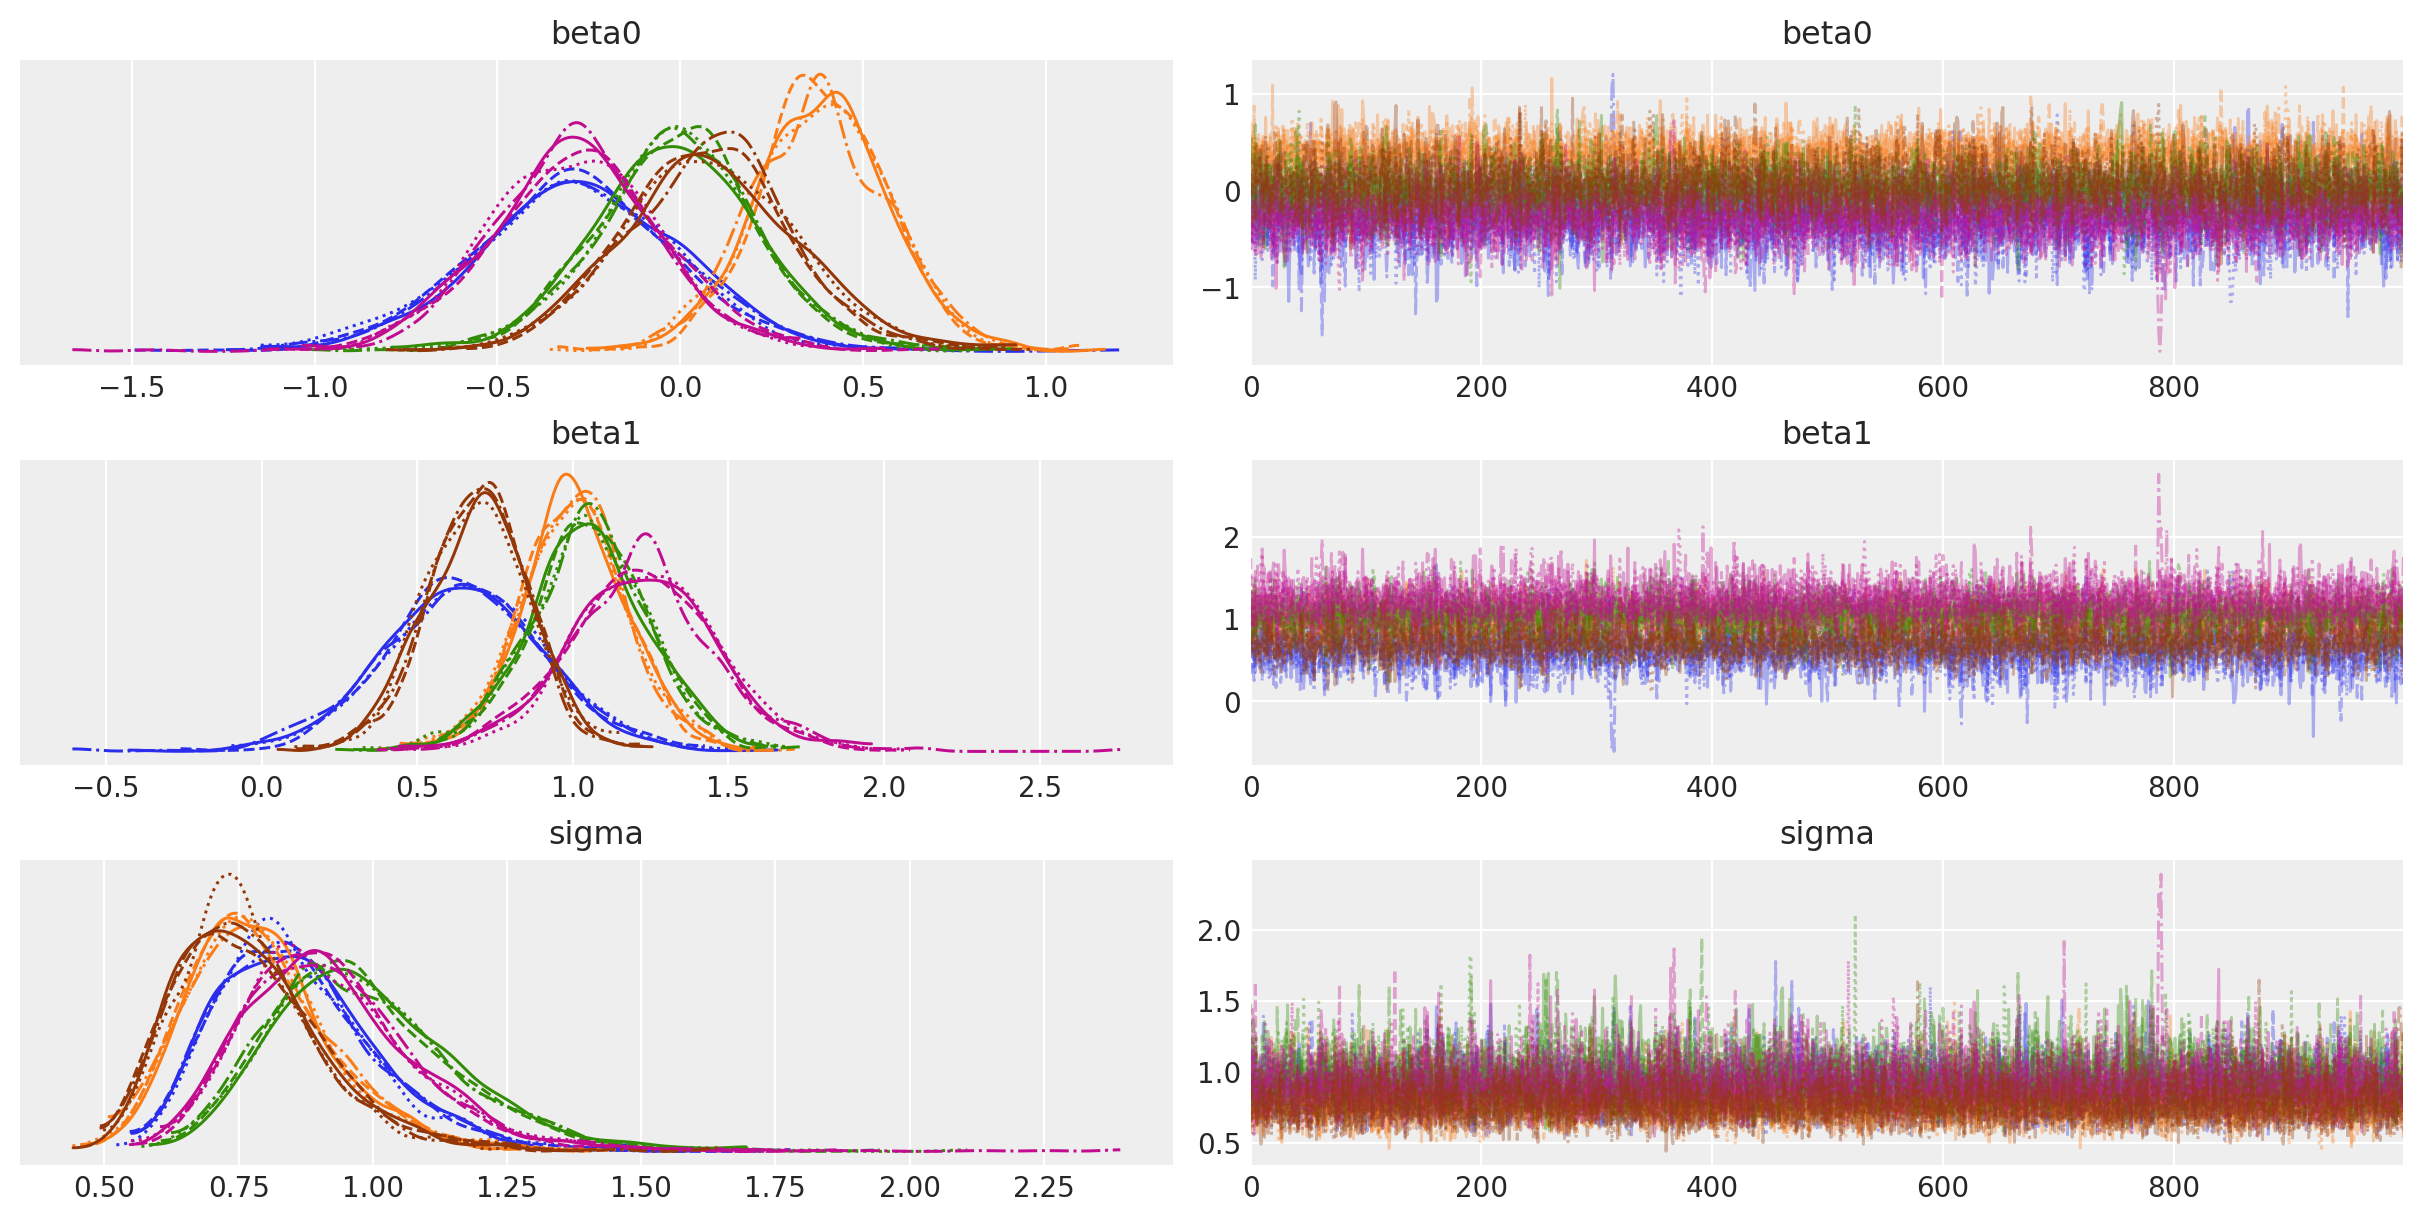

In [15]:
with ind_slope_inter:
    idata = pm.sample()
az.plot_trace(idata, filter_vars="regex", var_names=["~mu"]);

In [16]:
#ccreate values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(),10)
    for i,_ in enumerate(group_list)
]
g = [np.ones(10) * i for i,_ in enumerate(group_list)]
xi,g = np.concatenate(xi), np.concatenate(g)
#do posterior prediction
with ind_slope_inter:
    pm.set_data({"x":xi,"g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["mu","y"]))

Sampling: [y]


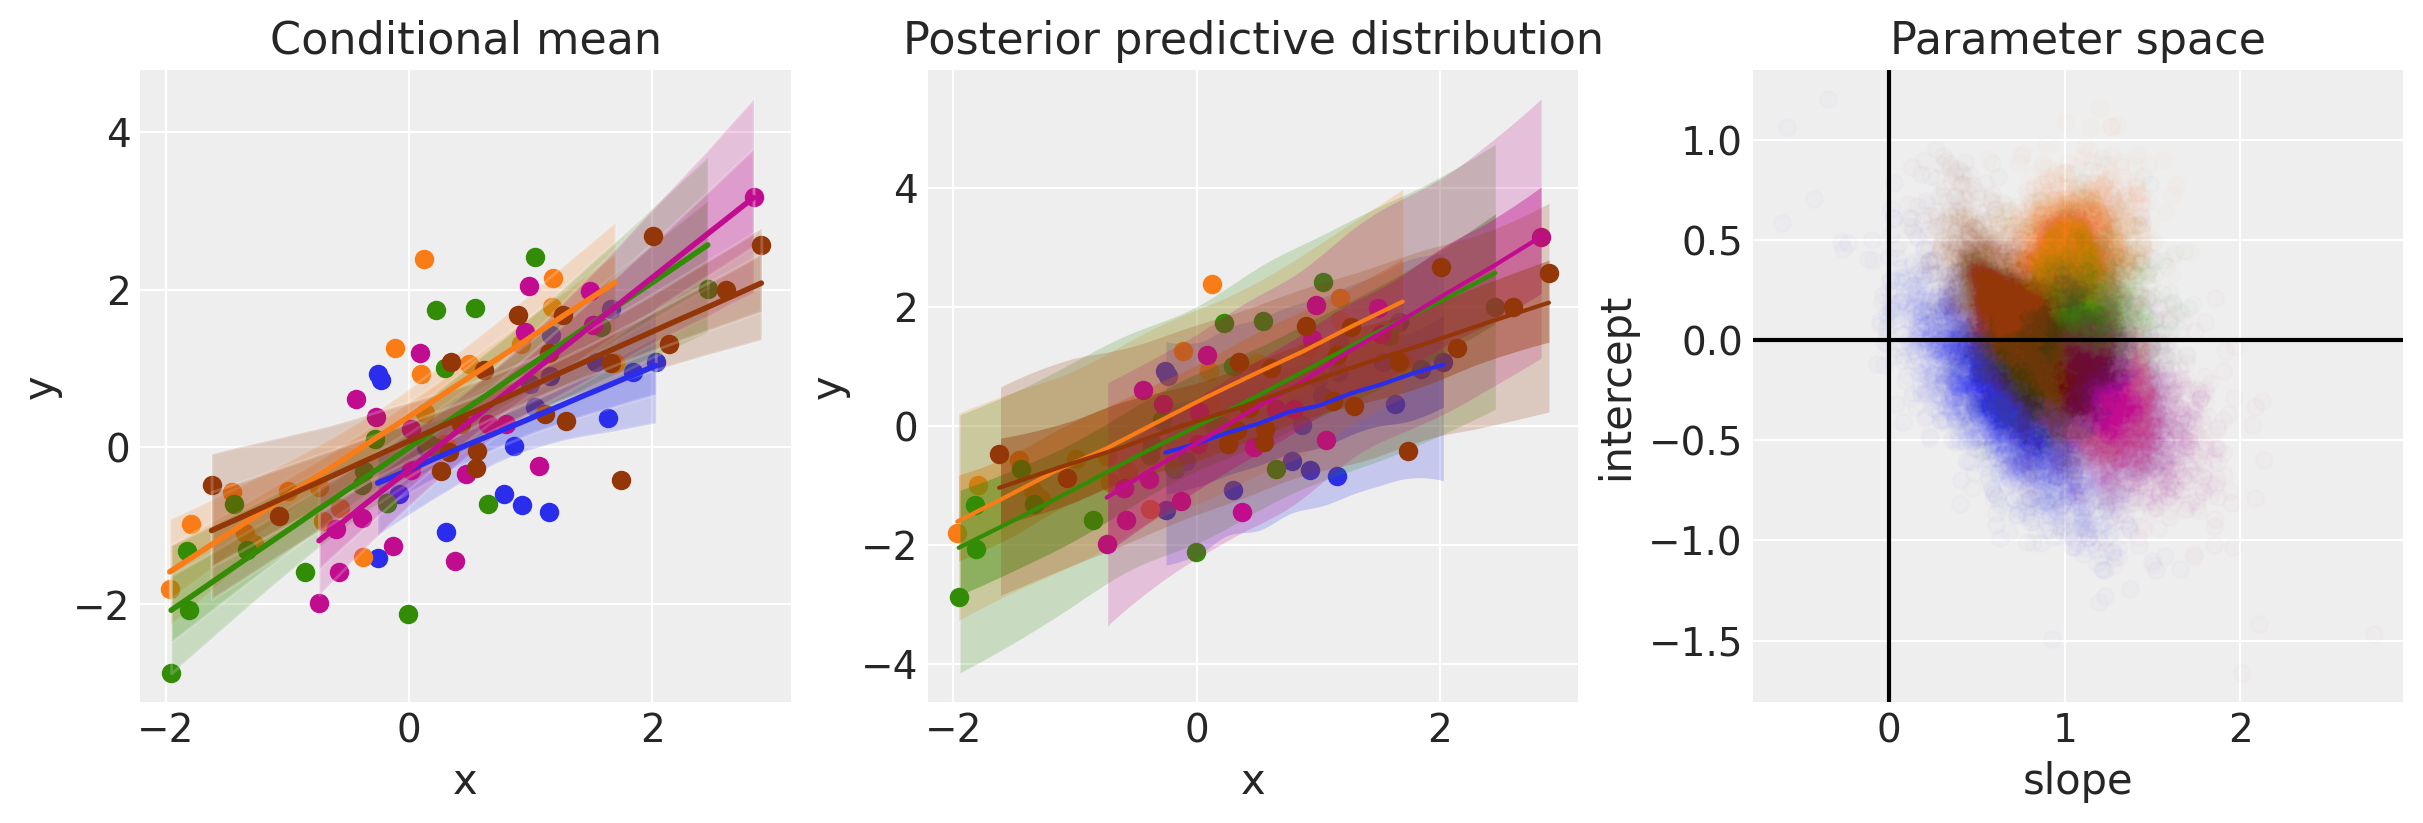

In [19]:
def get_ppy_for_group(group_list, group):
    """Get posterior predictive outcomes for observations from a given group"""
    return idata.posterior_predictive.y.data[:, :, group_list == group]


fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax[0].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.beta0.sel(group=groupname) + post.beta1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

# posterior prediction ----------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax[1].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # posterior mean and HDI's
    ax[1].plot(xi[g == i], np.mean(get_ppy_for_group(g, i), axis=(0, 1)), label=groupname)
    az.plot_hdi(
        xi[g == i],
        get_ppy_for_group(g, i),  # pp_y[:, :, g == i],
        hdi_prob=0.6,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.4, "linewidth": 0},
        ax=ax[1],
    )
    az.plot_hdi(
        xi[g == i],
        get_ppy_for_group(g, i),
        hdi_prob=0.95,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax[1],
    )

ax[1].set(xlabel="x", ylabel="y", title="Posterior predictive distribution")


# parameter space ---------------------------------------------------
for i, _ in enumerate(group_list):
    ax[2].scatter(
        az.extract(idata, var_names="beta1")[i, :],
        az.extract(idata, var_names="beta0")[i, :],
        color=f"C{i}",
        alpha=0.01,
        rasterized=True,
    )

ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space")
ax[2].axhline(y=0, c="k")
ax[2].axvline(x=0, c="k");

In contrast to plain regression model (Model1), when we model on the group level we can see than now the evidence points towards `positive` relationship between x and y

#### Model 3: Hierachical regression


In [35]:
non_centered = True
with pm.Model(coords=coords) as hier_reg:
    #hyper-priors
    inter_mu = pm.Normal("inter_mu", 0, sigma=1)
    inter_sigma = pm.HalfNormal("inter_sigma",sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior =pm.HalfNormal("sigma_hyperprior", sigma=0.5)
    #define prior
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")
    
    if non_centered:
        beta0_offset = pm.Normal("beta0_offset",0, sigma=1, dims="group")
        beta0 = pm.Deterministic("beta0", inter_mu + beta0_offset* inter_sigma, dims="group")
        beta1_offset = pm.Normal("beta1_offset", 0, sigma=1, dims="group")
        beta1 = pm.Deterministic("beta1", slope_mu + beta1_offset * slope_sigma, dims="group")
    else:
        beta0 = pm.Normal("beta0", inter_mu, sigma = inter_sigma, dims="group")
        beta1 = pm.Normal("beta1", slope_mu, sigma= slope_sigma, dims="group")
        
    #Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    #linear model
    mu = pm.Deterministic("mu", beta0[g] + beta1[g]*x, dims="obs_id")
    #define likelihood
    pm.Normal("y", mu=mu, sigma=sigma[g], observed=data.y, dims="obs_id")

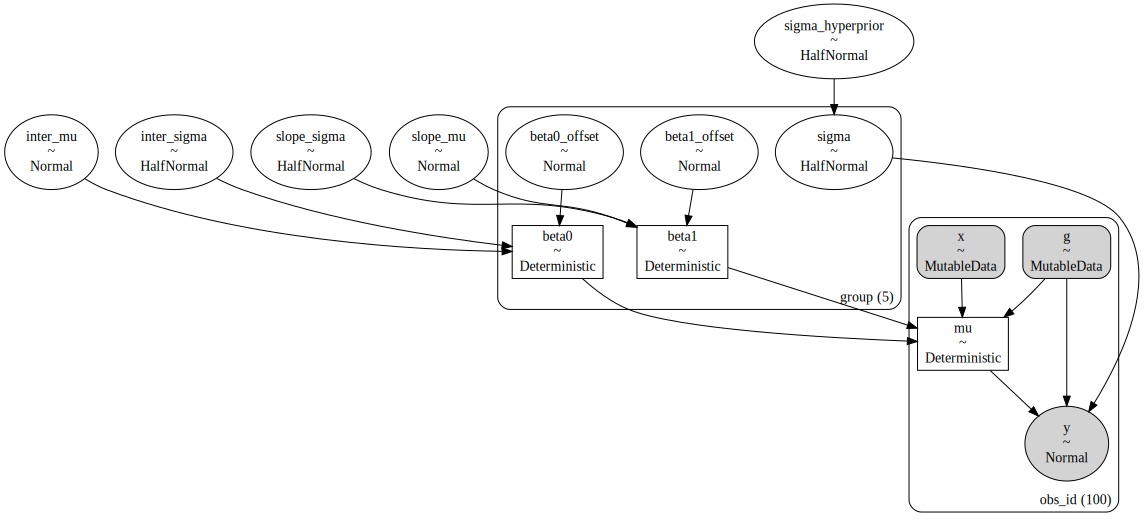

In [36]:
pm.model_to_graphviz(hier_reg)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [inter_mu, inter_sigma, slope_mu, slope_sigma, sigma_hyperprior, sigma, beta0_offset, beta1_offset]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 83 seconds.


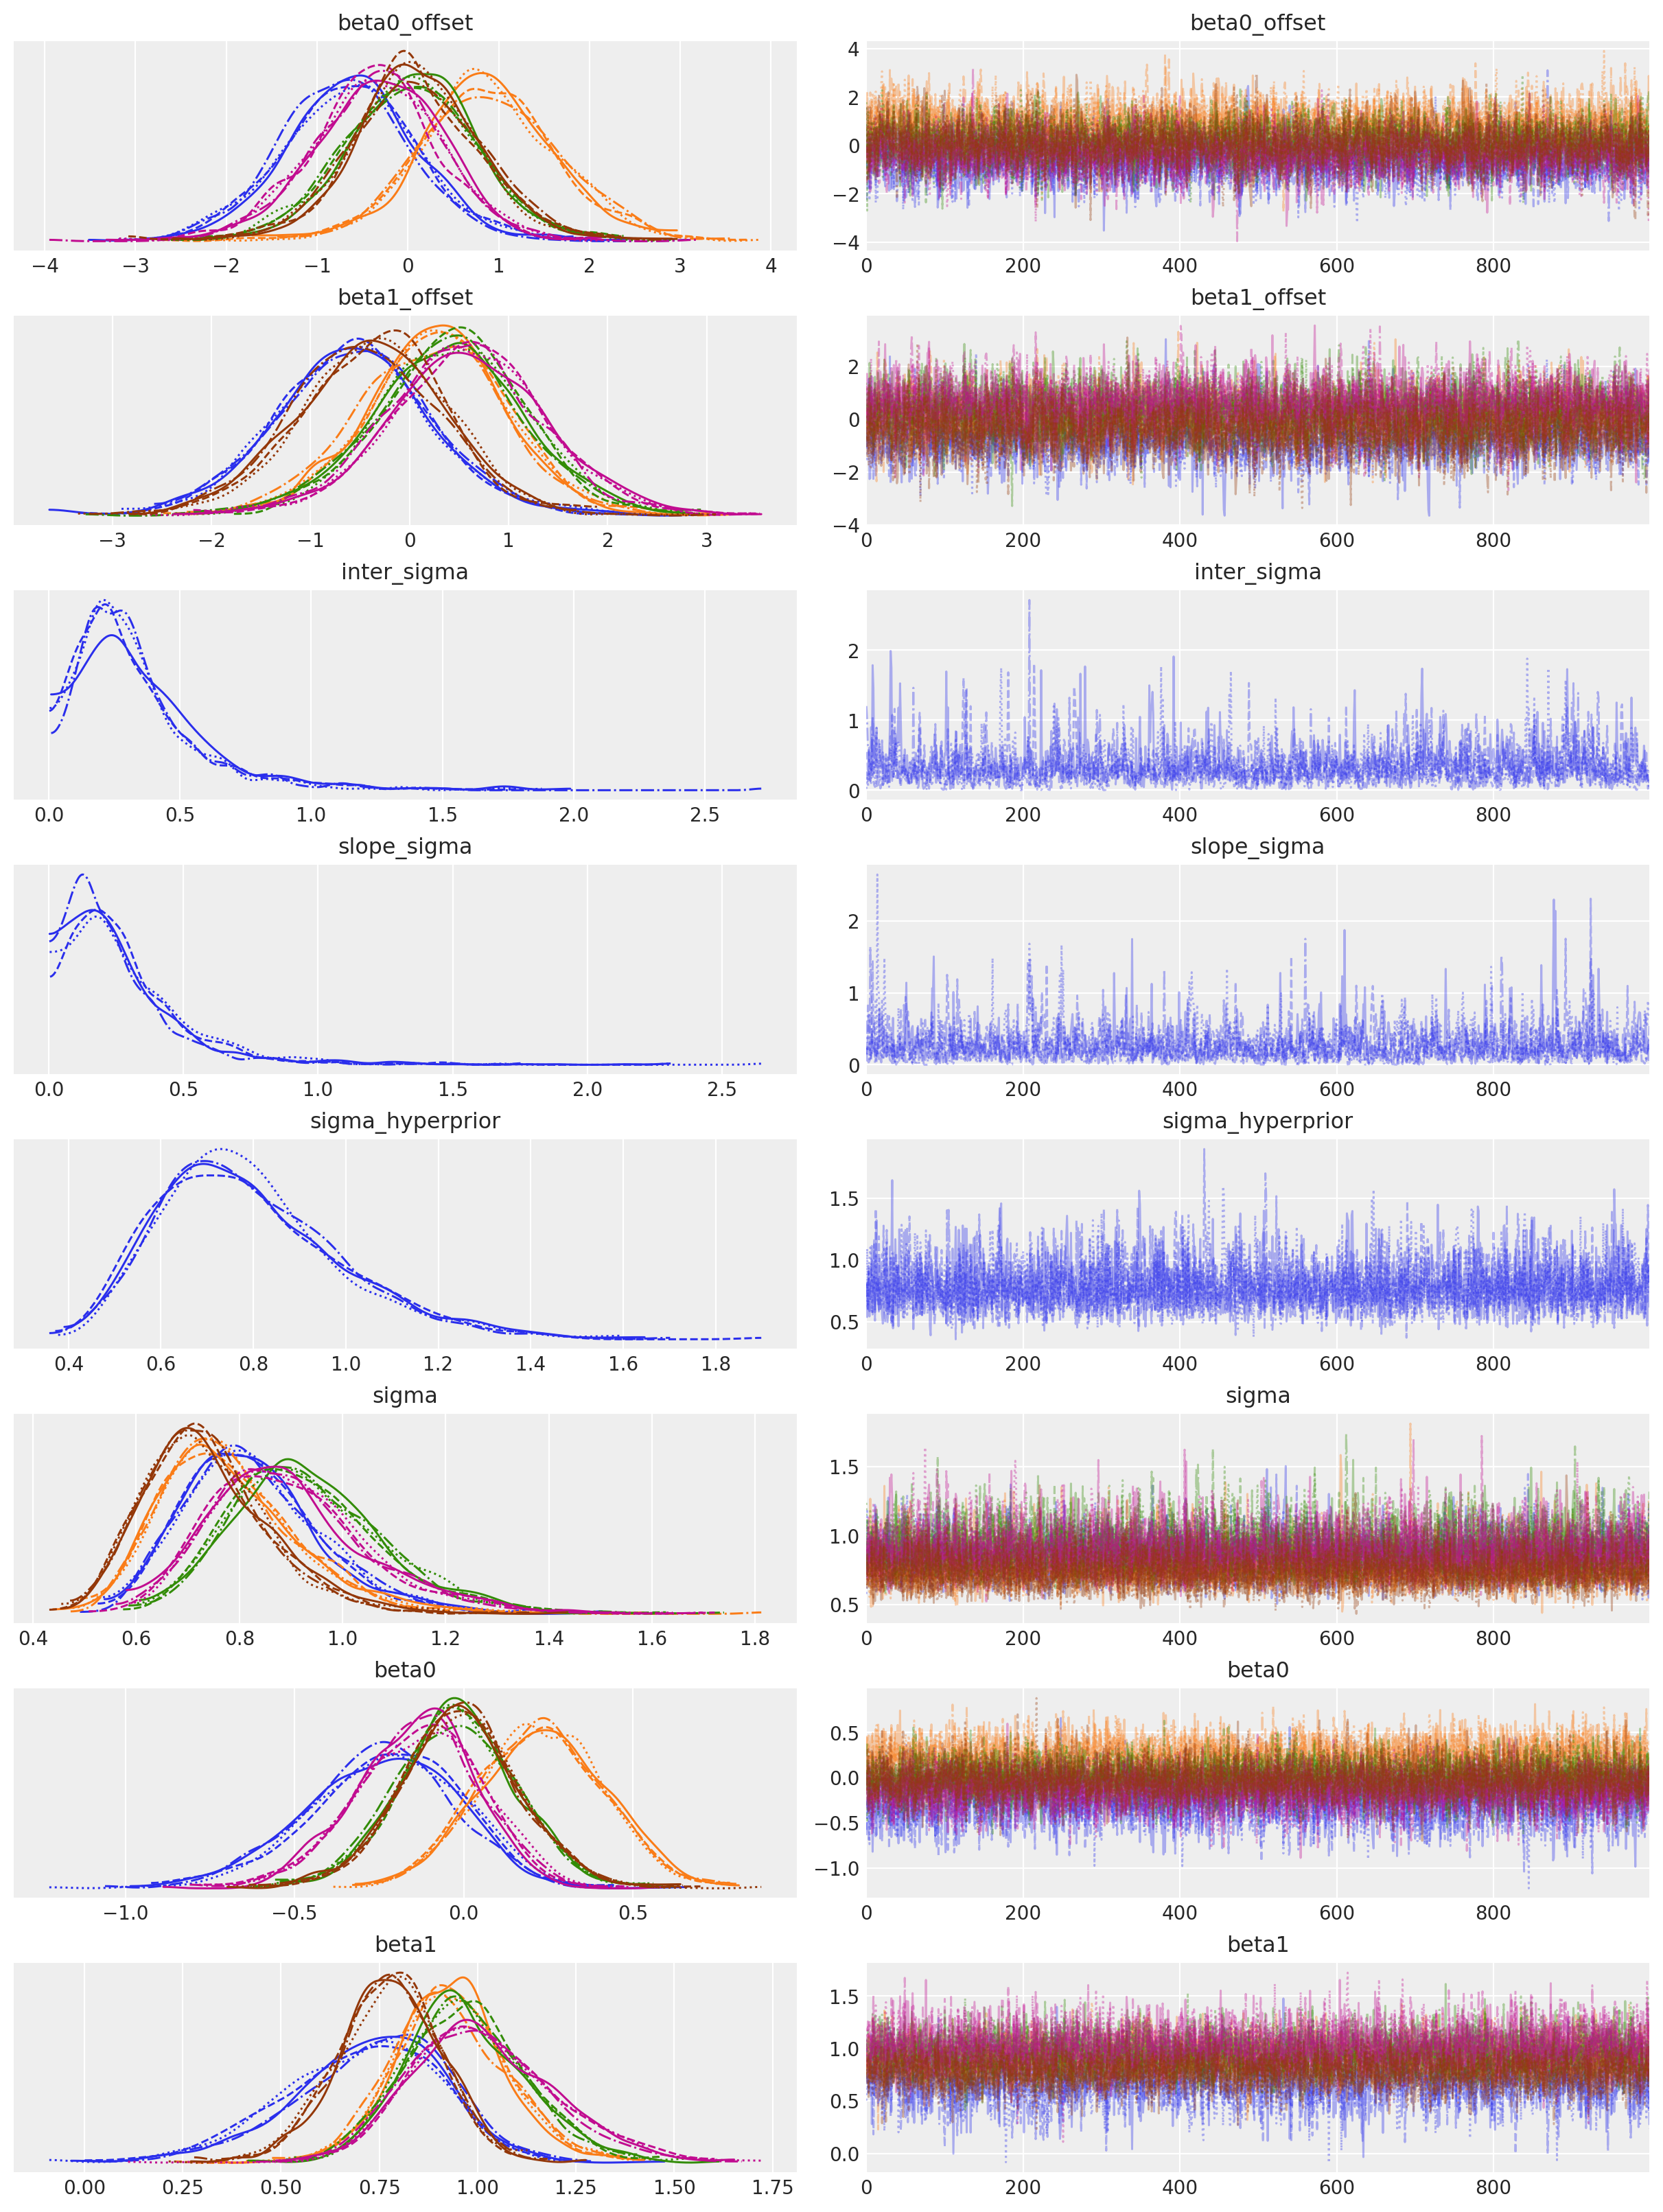

In [37]:
with hier_reg:
    idata = pm.sample(tune=2000, target_accept=0.99)
az.plot_trace(idata, filter_vars="regex", var_names=["~mu"]);

In [38]:
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(),10)
    for i,_ in enumerate(group_list)
]
g = [np.ones(10) * i for i,_ in enumerate(group_list)]
xi,g = np.concatenate(xi), np.concatenate(g)
#do the posterior prediction
with hier_reg:
    pm.set_data({"x":xi, "g":g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["mu","y"]))

Sampling: [y]


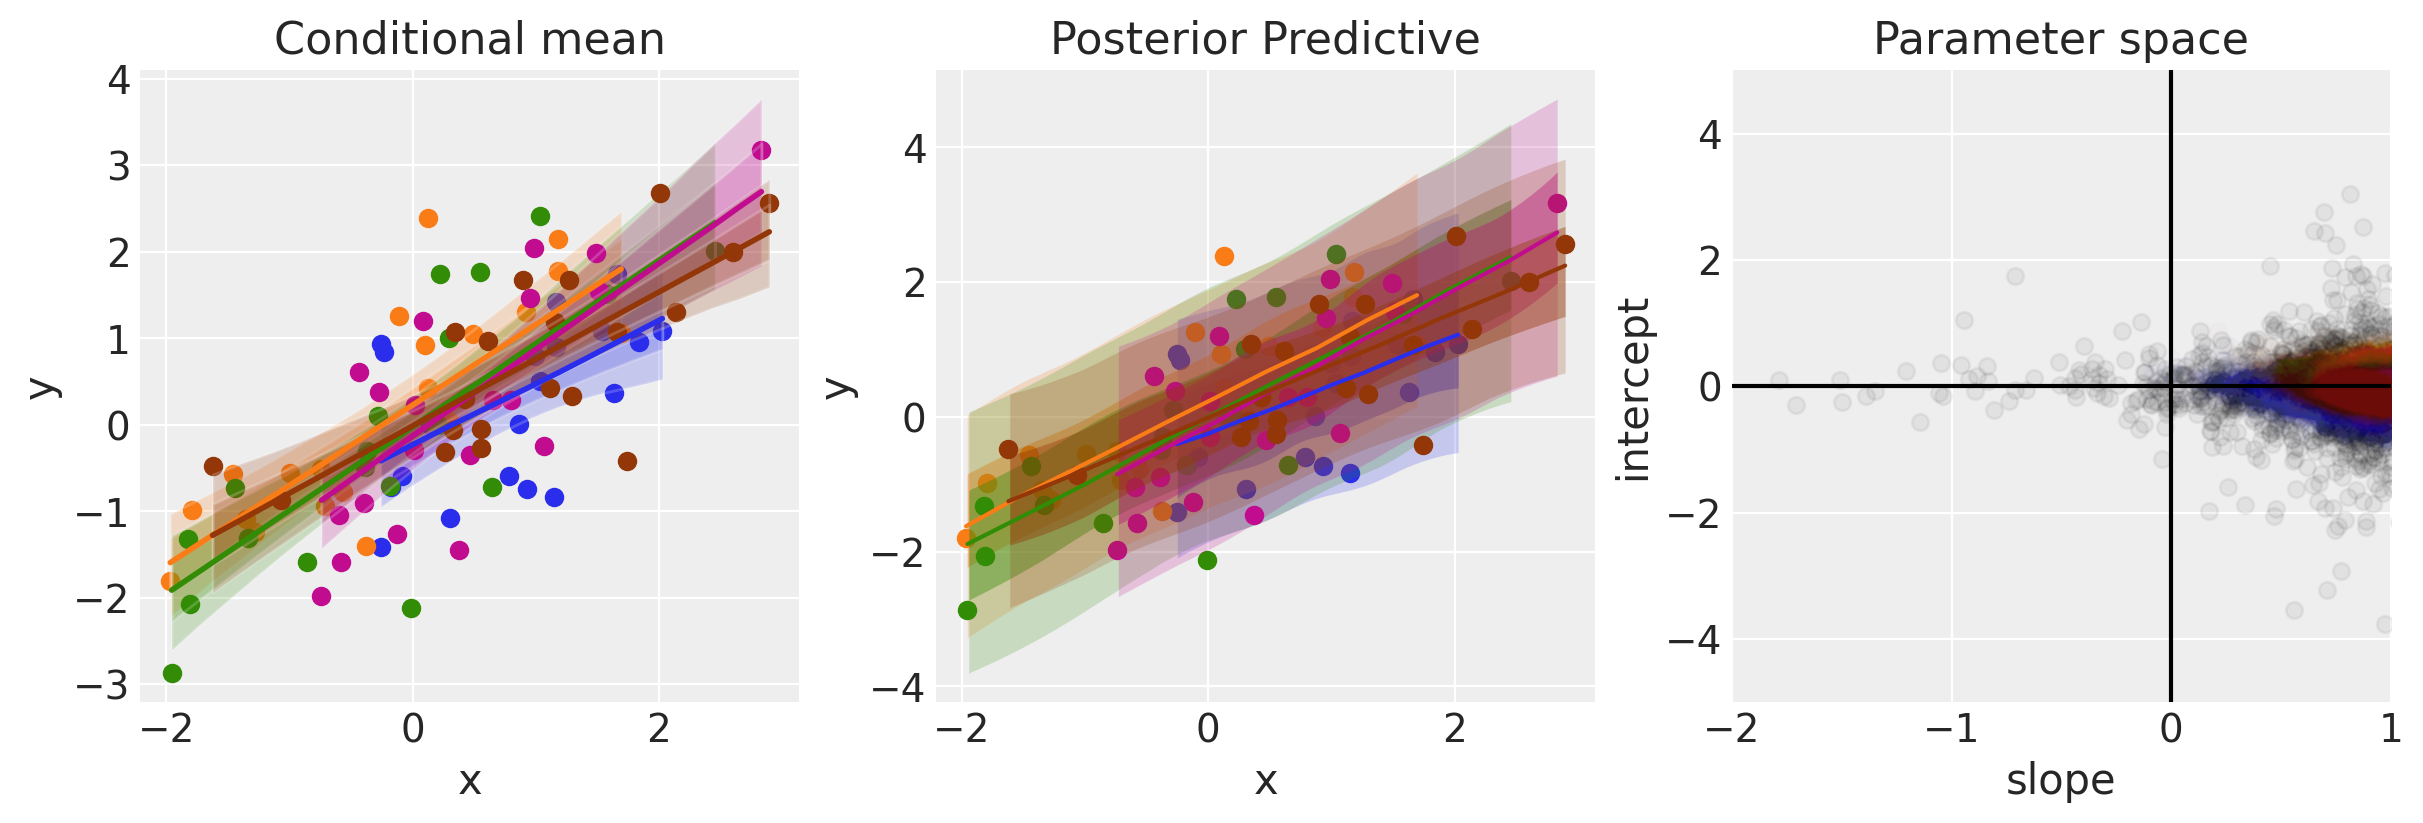

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax[0].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.beta0.sel(group=groupname) + post.beta1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax[0].fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax[0].plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax[0].set(xlabel="x", ylabel="y", title="Conditional mean")

# posterior prediction ----------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax[1].scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # posterior mean and HDI's
    ax[1].plot(xi[g == i], np.mean(get_ppy_for_group(g, i), axis=(0, 1)), label=groupname)
    az.plot_hdi(
        xi[g == i],
        get_ppy_for_group(g, i),
        hdi_prob=0.6,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.4, "linewidth": 0},
        ax=ax[1],
    )
    az.plot_hdi(
        xi[g == i],
        get_ppy_for_group(g, i),
        hdi_prob=0.95,
        color=f"C{i}",
        fill_kwargs={"alpha": 0.2, "linewidth": 0},
        ax=ax[1],
    )

ax[1].set(xlabel="x", ylabel="y", title="Posterior Predictive")

# parameter space ---------------------------------------------------
# plot posterior for population level slope and intercept
slope = rng.normal(
    az.extract(idata, var_names="slope_mu"),
    az.extract(idata, var_names="slope_sigma"),
)
intercept = rng.normal(
    az.extract(idata, var_names="inter_mu"),
    az.extract(idata, var_names="inter_sigma"),
)
ax[2].scatter(slope, intercept, color="k", alpha=0.05)
# plot posterior for group level slope and intercept
for i, _ in enumerate(group_list):
    ax[2].scatter(
        az.extract(idata, var_names="beta1")[i, :],
        az.extract(idata, var_names="beta0")[i, :],
        color=f"C{i}",
        alpha=0.01,
    )

ax[2].set(xlabel="slope", ylabel="intercept", title="Parameter space", xlim=[-2, 1], ylim=[-5, 5])
ax[2].axhline(y=0, c="k")
ax[2].axvline(x=0, c="k");

The panel on the right shows the posterior group level posterior of the slope and intercept parameters in black. this is particular visualization is little unclear however, it points towards the positive side, as indicated by posterior predictive plot and clearly shows positive relationship between x and y

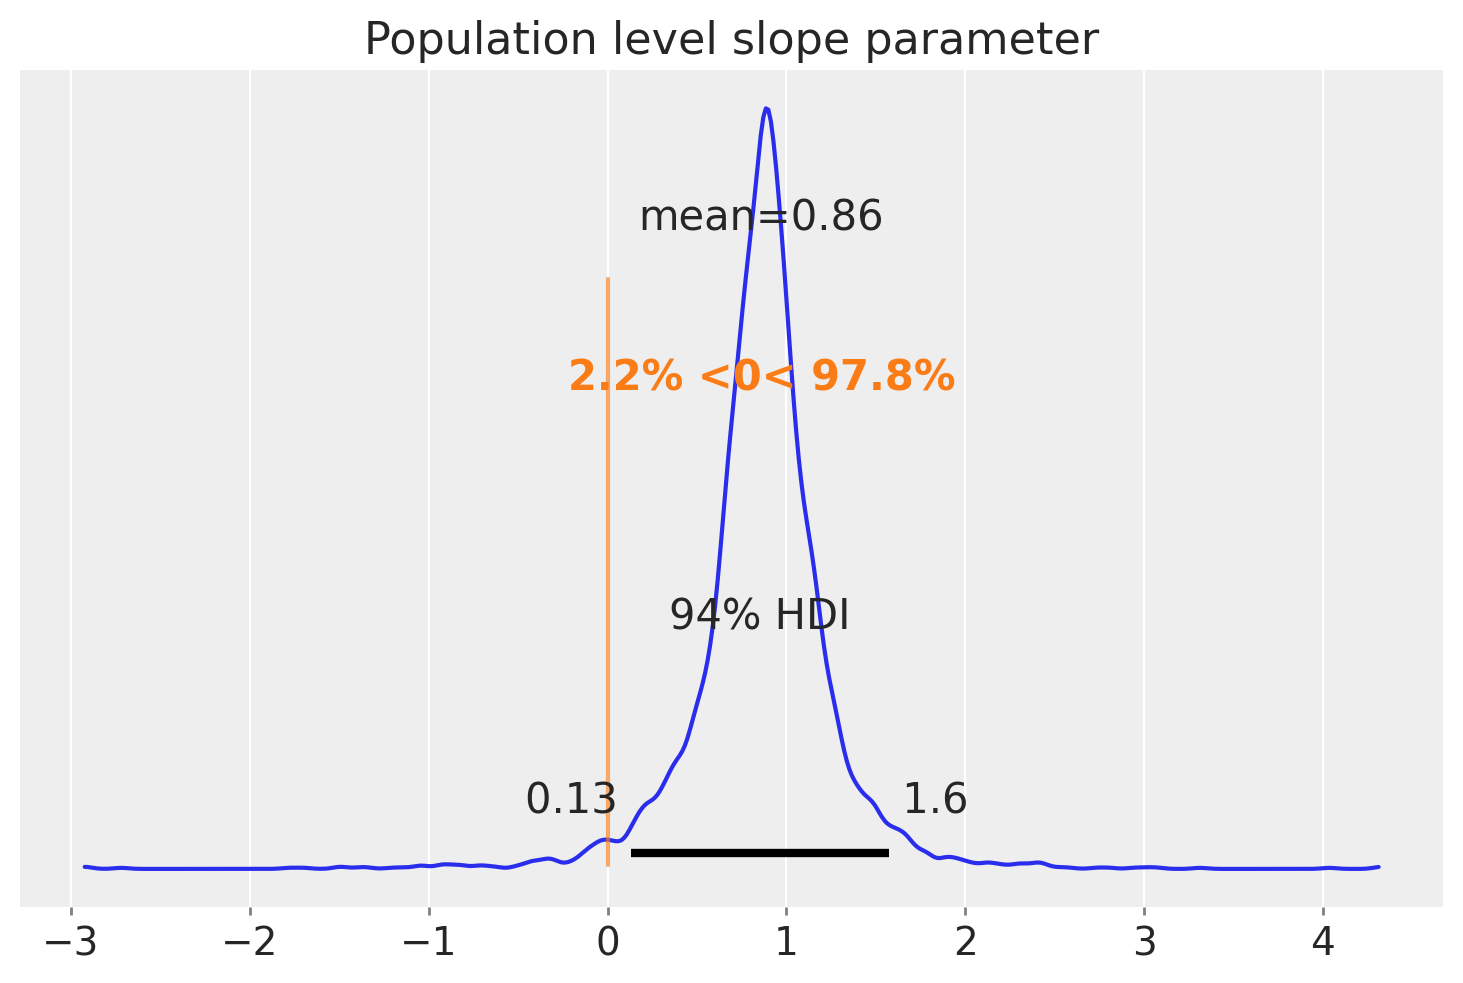

In [40]:
#Marginal distribution to see how much belief we have in the slope
az.plot_posterior(slope, ref_val=0)
plt.title("Population level slope parameter");

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat May 13 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.11.0

pytensor: 2.10.1

arviz     : 0.15.1
xarray    : 2023.2.0
numpy     : 1.23.5
pandas    : 1.5.3
pymc      : 5.1.2
matplotlib: 3.7.1

Watermark: 2.3.1

